# Algorithmic Trading Model using Technical Analysis Indicators Take 4 (Part 4)
### David Lowe
### May 4, 2020

SUMMARY: The purpose of this project is to construct and test an algorithmic trading model and document the end-to-end steps using a template.

Additional Notes: This is an adaptation of the momentum trading strategy from Chapter 2 of Learn Algorithmic Trading by Sebastien Donadio and Sourav Ghosh with Packt Publishing (https://www.packtpub.com/data/learn-algorithmic-trading-fundamentals-of-algorithmic-trading).

INTRODUCTION: This algorithmic trading model uses the support and resistance levels to generate trading signals for a mean-reversion trading strategy. The strategy is to create a buy order when the stock price stays in the support tolerance margin after a waiting period of two days. Conversely, the model generates a signal for a sell order when the stock price remains in the resistance tolerance margin after the same waiting period.

We apply the analysis on a stock for a fixed period and compare its return/loss to a simple long-only model. The long-only model will purchase the stock at the opening of day one and hold the stock through the entire time.

In iteration Take1, we constructed and tested a momentum trading model for the stock "GOOG" during the three years between 2017 and 2019 with an investment pool of 1,500 USD.

In iteration Take2, we constructed and tested a momentum trading model for the stock "GOOG" during the three years between 2017 and 2019 with an investment pool of 1,500 USD. We also changed the waiting period from two days to one day, three days, four days, and five days.

In iteration Take3, we constructed and tested a mean-reversion trading model for the stock "GOOG" during the three years between 2017 and 2019 with an investment pool of 1,500 USD.

In this Take4 iteration, we will construct and test a mean-reversion trading model for the stock "GOOG" during the three years between 2017 and 2019 with an investment pool of 1,500 USD. Instead, we will change the waiting period from two days to five days.

ANALYSIS: In iteration Take1, the momentum trading strategy returned 30.18%. In the meantime, the long-only approach achieved an accumulated return of 37.16%.

In iteration Take2, the momentum trading strategy with a waiting period of one day returned 16.36%. The momentum trading strategy with a waiting period of three days returned 21.70%. The momentum trading strategy with a waiting period of four days returned 27.16%. The momentum trading strategy with a waiting period of five days returned 27.62%.

In iteration Take3, the mean-reversion trading strategy with a waiting period of two days returned 3.65%.

In this Take4 iteration, the mean-reversion trading strategy with a waiting period of five days returned 6.49%.

CONCLUSION: For this period, the trading strategy did not outperform the more straightforward long-only approach, so we should consider modeling more and different methods for this stock.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Various sources as illustrated below.

Dataset Reference: Various sources as documented below.

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Develop Strategy and Train Model
4. Backtest Model
5. Evaluate Performance

## Task 1. Prepare Environment

In [1]:
# Install the necessary Python module(s) in Colab
# !pip install yfinance edgar

In [2]:
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import json
import requests
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
# Define the function for sending the status notification emails
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Algorithmic Trading Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Configure the plotting style
plt.style.use('seaborn')

# Specify the parameters for the trading strategy
window_width = 20
zone_margin = 0.2
waiting_period = 5

In [5]:
if notifyStatus: email_notify("Task 1. Prepare Environment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [6]:
start_date = datetime(2017, 1, 1)
print("Starting date:", start_date)
# end_date = datetime.now()
end_date = datetime(2019, 12, 31)
print("Ending date:", end_date)

stock_symbol = 'GOOG'
initial_capital = 1500

Starting date: 2017-01-01 00:00:00
Ending date: 2019-12-31 00:00:00


In [7]:
if notifyStatus: email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2. Acquire and Pre-Process Data

In [8]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Yahoo Finance

In [9]:
import yfinance as yf
yf.pdr_override()
stock_yahoo = pdr.get_data_yahoo(stock_symbol, start_date, end_date)
print(len(stock_yahoo), 'data points retrieved from the API call.')

[*********************100%***********************]  1 of 1 completed
753 data points retrieved from the API call.


In [10]:
stock_yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2017-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       753 non-null    float64
 1   High       753 non-null    float64
 2   Low        753 non-null    float64
 3   Close      753 non-null    float64
 4   Adj Close  753 non-null    float64
 5   Volume     753 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.2 KB


In [11]:
stock_yahoo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,778.809998,789.630005,775.799988,786.140015,786.140015,1657300
2017-01-04,788.359985,791.340027,783.159973,786.900024,786.900024,1073000
2017-01-05,786.080017,794.479980,785.020020,794.020020,794.020020,1335200
2017-01-06,795.260010,807.900024,792.203979,806.150024,806.150024,1640200
2017-01-09,806.400024,809.966003,802.830017,806.650024,806.650024,1274600


In [12]:
stock_yahoo.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,1355.869995,1359.800049,1346.510010,1348.839966,1348.839966,883100
2019-12-24,1348.500000,1350.260010,1342.780029,1343.560059,1343.560059,347500
2019-12-26,1346.170044,1361.327026,1344.469971,1360.400024,1360.400024,667500
2019-12-27,1362.989990,1364.530029,1349.310059,1351.890015,1351.890015,1038400
2019-12-30,1350.000000,1353.000000,1334.020020,1336.140015,1336.140015,1050900


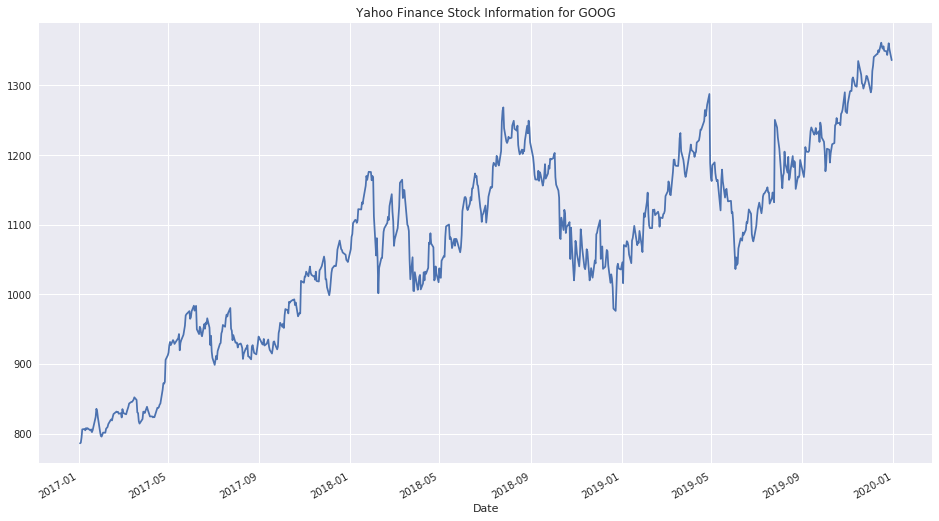

In [13]:
title_string = 'Yahoo Finance Stock Information for ' + stock_symbol
stock_yahoo['Adj Close'].plot(figsize=(16,9), title=title_string)
plt.show()

### 2.b) Alpha Vantage

In [14]:
# Check and see whether the API key is available
# alphavantage_key = os.environ.get('ALPHAVANTAGE_API')
# if (alphavantage_key==None): sys.exit("API key for Alpha Vantage not available. Script Processing Aborted!!!")
# alphavantage_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=%s&outputsize=full&apikey=%s" % (stock_symbol, alphavantage_key)

In [15]:
# response = requests.get(alphavantage_url)
# alpha_dict = json.loads(response.text)
# print(len(alpha_dict['Time Series (Daily)']), 'data points retrieved from the API call.')
# if (verbose): print(alpha_dict)

In [16]:
# stock_alpha = pd.DataFrame(alpha_dict['Time Series (Daily)']).T
# stock_alpha.index = pd.to_datetime(stock_alpha.index)
# stock_alpha = stock_alpha.sort_index(ascending = True)
# stock_alpha.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend', 'split_coef']
# stock_alpha = stock_alpha.astype(float)
# stock_alpha.info()

In [17]:
# stock_alpha.head()

In [18]:
# stock_alpha.tail()

In [19]:
# title_string = alpha_dict['Meta Data']['1. Information'] + ' for ' + alpha_dict['Meta Data']['2. Symbol']
# stock_alpha['close'].plot(figsize=(16,9), title=title_string)
# plt.show()

### 2.c) IEX Cloud

In [20]:
# Check and see whether the API key is available
# iexcloud_key = os.environ.get('IEXCLOUD_API')
# if (iexcloud_key==None): sys.exit("API key for IEX Cloud not available. Script Processing Aborted!!!")
# iexcloud_url = "https://cloud.iexapis.com/stable/stock/%s/chart/5y?token=%s" % (stock_symbol, iexcloud_key)

In [21]:
# response = requests.get(iexcloud_url)
# iex_dict = json.loads(response.text)
# print(len(iex_dict), 'data points retrieved from the API call.')
# if (verbose): print(iex_dict)

In [22]:
# stock_iexcloud = pd.DataFrame(iex_dict)
# stock_iexcloud.set_index('date', inplace=True)
# stock_iexcloud = stock_iexcloud.sort_index(ascending = True)
# stock_iexcloud.info()

In [23]:
# stock_iexcloud.head()

In [24]:
# stock_iexcloud.tail()

In [25]:
# title_string = 'IEX Cloud Historical Stock Information for ' + stock_symbol
# stock_iexcloud['close'].plot(figsize=(16,9), title=title_string)
# plt.show()

### 2.d) Quandl

In [26]:
# Code not activated below as Quandl requires a premium subscription for EOD stock data
# Code maintained here for future testing and uses

In [27]:
# Check and see whether the API key is available
# quandl_key = os.environ.get('QUANDL_API')
# if (quandl_key==None): sys.exit("API key for Quandl not available. Script Processing Aborted!!!")
# quandl_url = "https://www.quandl.com/api/v3/datasets/EOD/%s.json?api_key=%s" % (stock_symbol, quandl_key)

In [28]:
# response = requests.get(quandl_url)
# quandl_dict = json.loads(response.text)
# print(len(quandl_dict['dataset']['data']), 'data points retrieved from the API call.')
# if (verbose): print(quandl_dict)

In [29]:
# stock_quandl = pd.DataFrame(quandl_dict['dataset']['data'])
# stock_quandl.columns = quandl_dict['dataset']['column_names']
# stock_quandl.set_index('Date', inplace=True)
# stock_quandl = stock_quandl.sort_index(ascending = True)
# stock_quandl.info()

In [30]:
# stock_quandl.head()

In [31]:
# stock_quandl.tail()

In [32]:
# title_string = 'Quandl EOD Stock Information for ' + quandl_dict['dataset']['dataset_code']
# stock_quandl['Close'].plot(figsize=(16,9), title=title_string)
# plt.show()

### 2.e) Federal Reserve Economic Data (FRED)

In [33]:
# Code maintained here for future uses. Update the data series name below before use

In [34]:
# fred_data = 'DGS10'
# fred_series = pdr.DataReader(fred_data, 'fred', start_date, end_date)
# print(len(fred_series), 'data points retrieved from the API call.')

In [35]:
# fred_series.head()

In [36]:
# fred_series.tail()

In [37]:
# title_string = '10-Year Treasury Constant Maturity Rate'
# fred_series.plot(figsize=(16,9), title=title_string)
# plt.show()

### 2.f) Electronic Data Gathering, Analysis, and Retrieval system (EDGAR)

In [38]:
# Code maintained here for future uses. Update the company name and CKI number below before use

In [39]:
# import edgar
# edgar_filing = edgar.Company("MICROSOFT CORP", "0000789019")
# tree = edgar_filing.get_all_filings(filing_type = "10-K")
# docs = edgar_filing.get_documents(tree, no_of_documents=5)
# print(len(docs), "documents retrieved from EDGAR.")

In [40]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3. Develop Strategy and Train Model

In [41]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Set up the Dataframe for the Trading Model

In [42]:
# Select the data source and pricing columns to use for modeling
trading_model = stock_yahoo.loc[:, ['Open', 'Adj Close']]
# trading_model = stock_alpha.loc[start_date:end_date, ['adj_close']]
# trading_model = stock_iexcloud.loc[start_date:end_date, ['close']]
# trading_model = stock_quandl.loc[start_date:end_date, ['Adj_Close']]

# Set up the standard column name for modeling
trading_model.rename(columns={'Open': 'open_price', 'Adj Close': 'close_price'}, inplace=True)
trading_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2017-01-03 to 2019-12-30
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   753 non-null    float64
 1   close_price  753 non-null    float64
dtypes: float64(2)
memory usage: 17.6 KB


In [43]:
trading_model.head()

,open_price,close_price
Date,,
2017-01-03,778.809998,786.140015
2017-01-04,788.359985,786.900024
2017-01-05,786.080017,794.020020
2017-01-06,795.260010,806.150024
2017-01-09,806.400024,806.650024


In [44]:
trading_model.tail()

,open_price,close_price
Date,,
2019-12-23,1355.869995,1348.839966
2019-12-24,1348.500000,1343.560059
2019-12-26,1346.170044,1360.400024
2019-12-27,1362.989990,1351.890015
2019-12-30,1350.000000,1336.140015


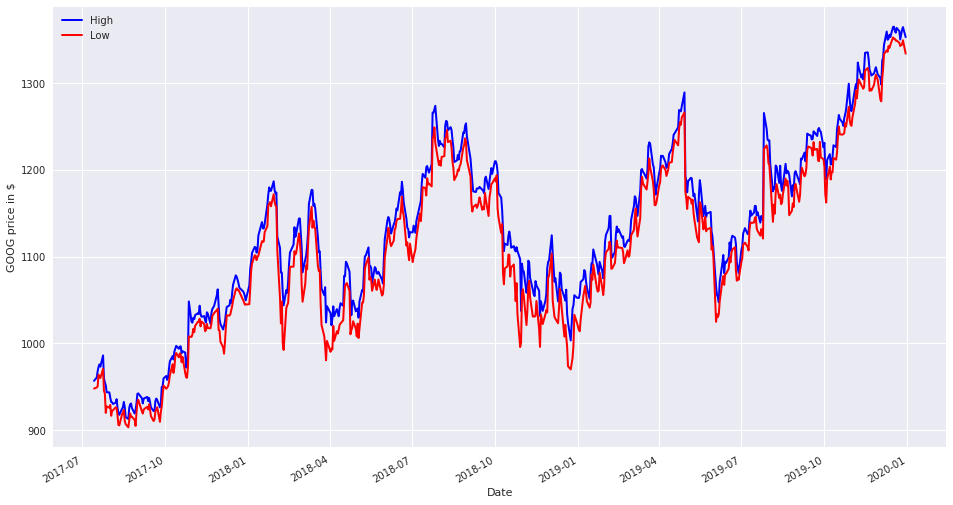

In [45]:
graph_data=stock_yahoo.tail(620)
lows=graph_data['Low']
highs=graph_data['High']
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel= ylabel)
highs.plot(ax=ax1, color='b', lw=2.)
lows.plot(ax=ax1, color='r', lw=2.)
plt.legend()
plt.show()

### 3.b) Set up the Analysis Table with Indicators

In [46]:
def trading_support_resistance(data, bin_width=20, margin=0.2, period=2):
    in_support=0
    in_resistance=0

    for x in range(bin_width, len(data)):
        data_section = data[x - bin_width:x + 1]
        support_level = min(data_section['close_price'])
        resistance_level = max(data_section['close_price'])
        range_level = resistance_level-support_level
        data['res'][x] = resistance_level
        data['sup'][x] = support_level
        data['sup_tolerance'][x] = support_level + (margin * range_level)
        data['res_tolerance'][x] = resistance_level - (margin * range_level)
        
        if (data['close_price'][x] >= data['res_tolerance'][x]) and (data['close_price'][x] <= data['res'][x]):
            in_resistance+=1
            data['res_count'][x] = in_resistance
        elif (data['close_price'][x] <= data['sup_tolerance'][x]) and (data['close_price'][x] >= data['sup'][x]):
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support=0
            in_resistance=0
        if in_resistance > period:
            data['signal'][x] = 0
        elif in_support > period:
            data['signal'][x] = 1
        else:
            data['signal'][x] = data['signal'][x-1]
            
        data['positions']=data['signal'].diff()

In [47]:
trading_model['sup_tolerance'] = np.zeros(len(trading_model))
trading_model['res_tolerance'] = np.zeros(len(trading_model))
trading_model['sup_count'] = np.zeros(len(trading_model))
trading_model['res_count'] = np.zeros(len(trading_model))
trading_model['sup'] = np.zeros(len(trading_model))
trading_model['res'] = np.zeros(len(trading_model))
trading_model['signal'] = np.zeros(len(trading_model))
trading_model['positions'] = np.zeros(len(trading_model))

trading_support_resistance(trading_model, window_width, zone_margin, waiting_period)

# List the Buy signals
trading_model[trading_model.positions == 1.0]

,open_price,close_price,sup_tolerance,res_tolerance,sup_count,res_count,sup,res,signal,positions
Date,,,,,,,,,,
2017-08-11,907.969971,914.390015,921.859998,965.720020,6.0,0.0,907.239990,980.340027,1.0,1.0
2018-04-04,993.409973,1025.140015,1036.547998,1132.512000,6.0,0.0,1004.559998,1164.500000,1.0,1.0
2018-09-11,1161.630005,1177.359985,1181.572021,1232.368042,6.0,0.0,1164.640015,1249.300049,1.0,1.0
2019-05-14,1137.209961,1120.439941,1153.867944,1254.151953,6.0,0.0,1120.439941,1287.579956,1.0,1.0


In [48]:
# List the Sell signals
trading_model[trading_model.positions == -1.0]

,open_price,close_price,sup_tolerance,res_tolerance,sup_count,res_count,sup,res,signal,positions
Date,,,,,,,,,,
2017-10-04,957.000000,951.679993,923.821997,950.287988,0.0,6.0,915.000000,959.109985,0.0,-1.0
2018-06-07,1131.319946,1123.859985,1076.187964,1123.792017,0.0,6.0,1060.319946,1139.660034,0.0,-1.0
2019-01-11,1063.180054,1057.189941,996.231982,1056.268018,0.0,6.0,976.219971,1076.280029,0.0,-1.0
2019-07-16,1146.000000,1153.579956,1091.523999,1138.065967,0.0,6.0,1076.010010,1153.579956,0.0,-1.0


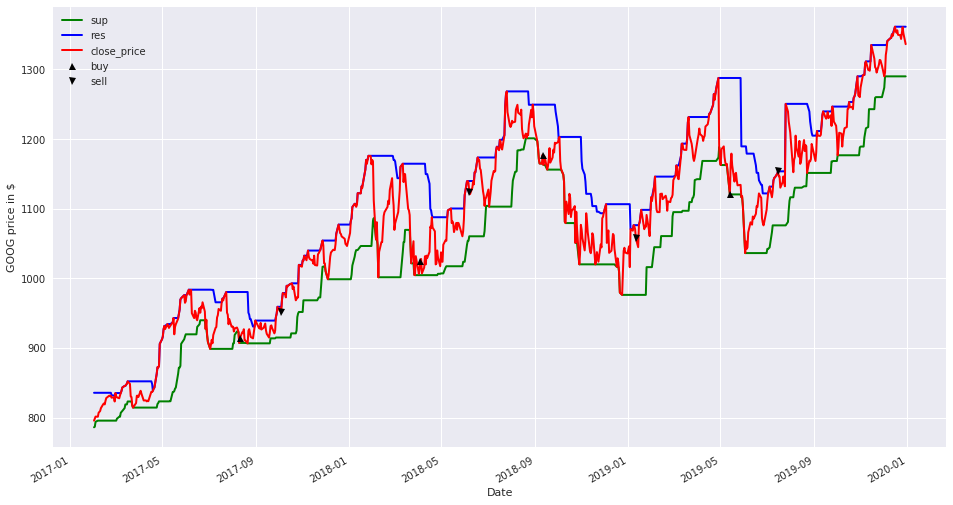

In [49]:
graph_data = trading_model[window_width:]
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel)
graph_data['sup'].plot(ax=ax1, color='g', lw=2.)
graph_data['res'].plot(ax=ax1, color='b', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(graph_data.loc[graph_data.positions == 1.0].index, graph_data.close_price[graph_data.positions == 1.0], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.positions == -1.0].index, graph_data.close_price[graph_data.positions == -1.0], 'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()

In [50]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4. Backtest Model

In [51]:
if notifyStatus: email_notify("Task 4. Backtest Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
# Construct a portfolio to track the transactions and returns
portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction',
                                                             'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
portfolio.iloc[0]['trade_action'] = 0
portfolio.iloc[0]['qty_onhand'] = 0
portfolio.iloc[0]['cost_basis'] = 0.00
portfolio.iloc[0]['sold_transaction'] = 0.00
portfolio.iloc[0]['gain_loss'] = 0.00
portfolio.iloc[0]['cash_onhand'] = initial_capital
portfolio.iloc[0]['position_value'] = 0.00
portfolio.iloc[0]['total_position'] = initial_capital
portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_capital

# The conditional parameters below determine how the trading strategy will be carried out
for i in range(1, len(portfolio)):
    if ((trading_model.iloc[i]['positions'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0)):
        portfolio.iloc[i]['trade_action'] = 1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
        recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
    elif ((not trading_model.iloc[i]['positions'] == 0) and (portfolio.iloc[i-1]['qty_onhand'] > 0)):
        portfolio.iloc[i]['trade_action'] = -1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = 0.00
        portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
        portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
        recent_cost = 0.00
        print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
    else:
        portfolio.iloc[i]['trade_action'] = 0
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
        portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
    portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
    portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
    portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_capital

BOUGHT QTY: 1 on 2017-08-11 00:00:00 at the price of 907.969970703125
SOLD QTY: -1 on 2017-10-04 00:00:00 at the price of 957.0
BOUGHT QTY: 1 on 2018-04-04 00:00:00 at the price of 993.4099731445312
SOLD QTY: -1 on 2018-06-07 00:00:00 at the price of 1131.3199462890625
BOUGHT QTY: 1 on 2018-09-11 00:00:00 at the price of 1161.6300048828125
SOLD QTY: -1 on 2019-01-11 00:00:00 at the price of 1063.1800537109375
BOUGHT QTY: 1 on 2019-05-14 00:00:00 at the price of 1137.2099609375
SOLD QTY: -1 on 2019-07-16 00:00:00 at the price of 1146.0


In [53]:
portfolio[portfolio.trade_action == 1]

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,,,,
2017-08-11,1,1,907.97,0,0,592.03,914.39,1506.42,6.42004
2018-04-04,1,1,993.41,0,0,555.62,1025.14,1580.76,80.7601
2018-09-11,1,1,1161.63,0,0,525.31,1177.36,1702.67,202.67
2019-05-14,1,1,1137.21,0,0,451.28,1120.44,1571.72,71.72


In [54]:
portfolio[portfolio.trade_action == -1]

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,,,,
2017-10-04,-1,0,0,957,49.03,1549.03,0,1549.03,49.03
2018-06-07,-1,0,0,1131.32,137.91,1686.94,0,1686.94,186.94
2019-01-11,-1,0,0,1063.18,-98.45,1588.49,0,1588.49,88.4901
2019-07-16,-1,0,0,1146,8.79004,1597.28,0,1597.28,97.2801


In [55]:
portfolio.head(20)

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,,,,
2017-01-03,0,0,0,0,0,1500,0,1500,0
2017-01-04,0,0,0,0,0,1500,0,1500,0
2017-01-05,0,0,0,0,0,1500,0,1500,0
2017-01-06,0,0,0,0,0,1500,0,1500,0
2017-01-09,0,0,0,0,0,1500,0,1500,0
2017-01-10,0,0,0,0,0,1500,0,1500,0
2017-01-11,0,0,0,0,0,1500,0,1500,0
2017-01-12,0,0,0,0,0,1500,0,1500,0
2017-01-13,0,0,0,0,0,1500,0,1500,0


In [56]:
portfolio.tail(20)

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,,,,
2019-12-02,0,0,0,0,0,1597.28,0,1597.28,97.2801
2019-12-03,0,0,0,0,0,1597.28,0,1597.28,97.2801
2019-12-04,0,0,0,0,0,1597.28,0,1597.28,97.2801
2019-12-05,0,0,0,0,0,1597.28,0,1597.28,97.2801
2019-12-06,0,0,0,0,0,1597.28,0,1597.28,97.2801
2019-12-09,0,0,0,0,0,1597.28,0,1597.28,97.2801
2019-12-10,0,0,0,0,0,1597.28,0,1597.28,97.2801
2019-12-11,0,0,0,0,0,1597.28,0,1597.28,97.2801
2019-12-12,0,0,0,0,0,1597.28,0,1597.28,97.2801


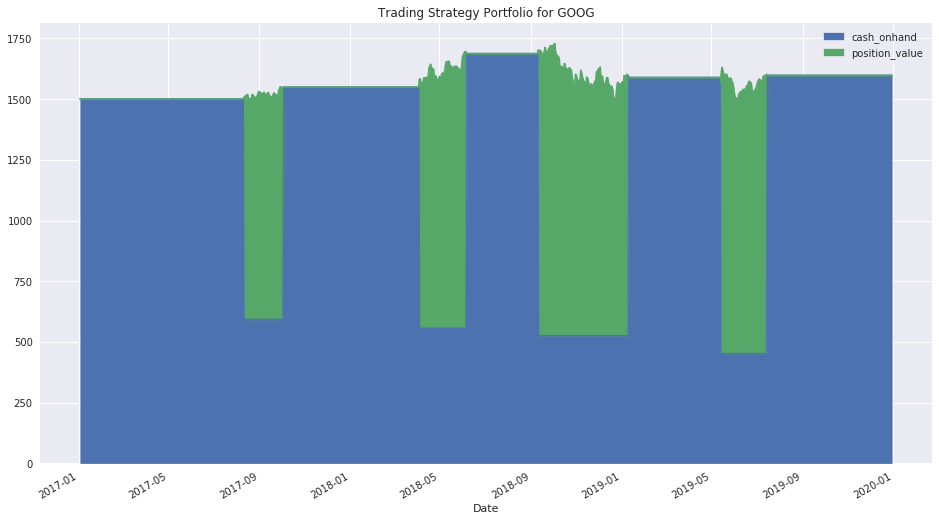

In [57]:
title_string = 'Trading Strategy Portfolio for ' + stock_symbol
portfolio[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [58]:
if notifyStatus: email_notify("Task 4. Backtest Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5. Evaluate Performance

In [59]:
if notifyStatus: email_notify("Task 5. Evaluate Performance has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [60]:
# Construct a long only as a benchmark for the trading strategy
benchmark = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cash_onhand', 'position_value', 'total_position', "accumu_return"])
benchmark.iloc[0]['trade_action'] = 1
benchmark.iloc[0]['qty_onhand'] = benchmark.iloc[0]['trade_action']
benchmark.iloc[0]['cash_onhand'] = initial_capital - (trading_model.iloc[0]['open_price'] * benchmark.iloc[0]['trade_action'])
benchmark.iloc[0]['position_value'] = trading_model.iloc[0]['open_price']
benchmark.iloc[0]['total_position'] = initial_capital
benchmark.iloc[0]['accumu_return'] = benchmark.iloc[0]['total_position'] - initial_capital

for i in range(1, len(portfolio)):
    benchmark.iloc[i]['trade_action'] = 0
    benchmark.iloc[i]['qty_onhand'] = benchmark.iloc[i-1]['qty_onhand']
    benchmark.iloc[i]['cash_onhand'] = benchmark.iloc[i-1]['cash_onhand']
    benchmark.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * benchmark.iloc[i]['qty_onhand']
    benchmark.iloc[i]['total_position'] = benchmark.iloc[i]['cash_onhand'] + benchmark.iloc[i]['position_value']
    benchmark.iloc[i]['accumu_return'] = benchmark.iloc[i]['total_position'] - initial_capital

benchmark.head(10)

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,
2017-01-03,1,1,721.19,778.81,1500,0
2017-01-04,0,1,721.19,786.9,1508.09,8.09003
2017-01-05,0,1,721.19,794.02,1515.21,15.21
2017-01-06,0,1,721.19,806.15,1527.34,27.34
2017-01-09,0,1,721.19,806.65,1527.84,27.84
2017-01-10,0,1,721.19,804.79,1525.98,25.98
2017-01-11,0,1,721.19,807.91,1529.1,29.1
2017-01-12,0,1,721.19,806.36,1527.55,27.55
2017-01-13,0,1,721.19,807.88,1529.07,29.07


In [61]:
benchmark.tail(10)

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,
2019-12-16,0,1,721.19,1361.17,2082.36,582.36
2019-12-17,0,1,721.19,1355.12,2076.31,576.31
2019-12-18,0,1,721.19,1352.62,2073.81,573.81
2019-12-19,0,1,721.19,1356.04,2077.23,577.23
2019-12-20,0,1,721.19,1349.59,2070.78,570.78
2019-12-23,0,1,721.19,1348.84,2070.03,570.03
2019-12-24,0,1,721.19,1343.56,2064.75,564.75
2019-12-26,0,1,721.19,1360.4,2081.59,581.59
2019-12-27,0,1,721.19,1351.89,2073.08,573.08


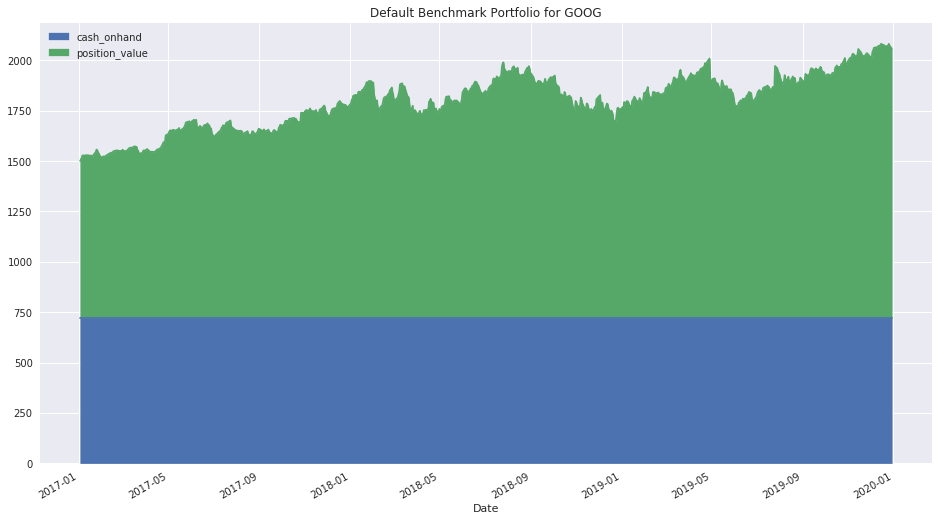

In [62]:
title_string = 'Default Benchmark Portfolio for ' + stock_symbol
benchmark[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [63]:
# Build a performance data frame to display the returns from the strategy and benchmark
performance = pd.DataFrame(index=trading_model.index)
performance['strategy'] = portfolio['accumu_return']
performance['benchmark'] = benchmark['accumu_return']

performance.tail(10)

,strategy,benchmark
Date,,
2019-12-16,97.2801,582.36
2019-12-17,97.2801,576.31
2019-12-18,97.2801,573.81
2019-12-19,97.2801,577.23
2019-12-20,97.2801,570.78
2019-12-23,97.2801,570.03
2019-12-24,97.2801,564.75
2019-12-26,97.2801,581.59
2019-12-27,97.2801,573.08


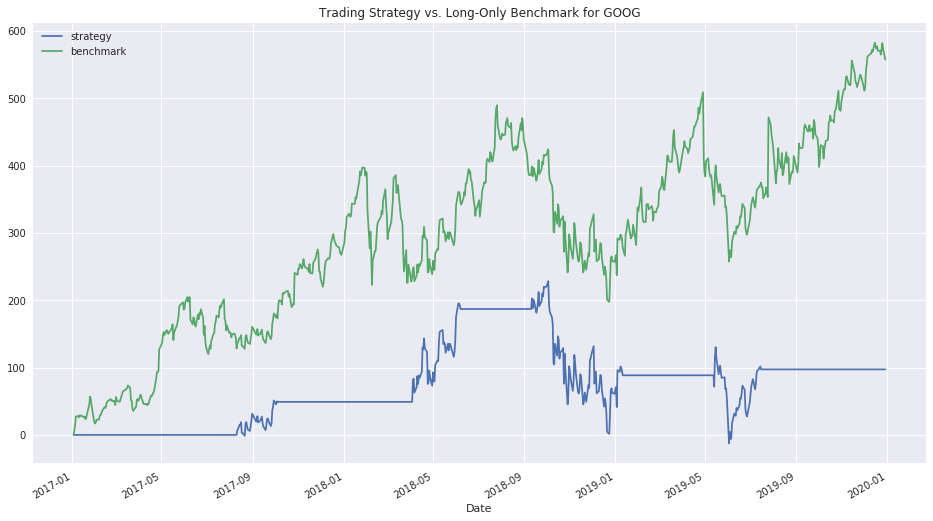

In [64]:
title_string = 'Trading Strategy vs. Long-Only Benchmark for ' + stock_symbol
performance[['strategy','benchmark']].plot(figsize=(16,9), title=title_string)
plt.show()

In [65]:
print('The accumulated return/loss from the trading strategy: %.2f percent' % (performance.iloc[-1]['strategy'] / initial_capital * 100))
print('The accumulated return/loss from the long-only benchmark: %.2f percent' % (performance.iloc[-1]['benchmark'] / initial_capital * 100))

The accumulated return/loss from the trading strategy: 6.49 percent
The accumulated return/loss from the long-only benchmark: 37.16 percent


In [66]:
if notifyStatus: email_notify("Task 5. Evaluate Performance completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [67]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:21.074333
